# Fastspec and Observed Spectra

## Author: Ashod Khederlarian, University of Pittsburgh

This notebook illustrates how to use data from the fastspec fits files to obtain the fitted fastspec spectrum and compare it with the observed healpix spectrum.

## Environment

This notebook will work with the default DESI environment on NERSC. You can also create your own environment and install all the packages manually. Everything is pip installable except for desiutil, which you can install using desiInstall (on NERSC), https://desiutil.readthedocs.io/en/latest/desiInstall.html.


In [1]:
from astropy.io import fits
from astropy.table import Table, join
import numpy as np
import pylab as plt
import healpy
from scipy.signal import medfilt
from desiutil.dust import SFDMap
from desiutil.dust import dust_transmission
import os

plt.rcParams['figure.figsize'] = [25, 10]

In [2]:
# reading fastspec catalog for fuji BGS bright

sv = '1'
fastspec_path = "/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/v2.0/catalogs/fastspec-fuji-sv"+sv+"-bright.fits"
data = Table.read(fastspec_path, hdu=1)
metadata = Table.read(fastspec_path, hdu=2)

In [10]:
#data.columns

In [11]:
#metadata.columns

A DESI target at a given RA and DEC can have many spectra observed on different runs. These spectra are co-added into a single spectrum and are stored in the HEALPIX catalogs. See documentation at https://data.desi.lbl.gov/doc/.

Fastspecfit is applied on the co-added spectra, so to fetch the spectrum of an object in the fastspec catalog we need its RA and DEC.

In [5]:
# based on a target_id retrieve redshift, RA, and DEC
target_id = data['TARGETID'][1000] # this is a random object from the sample.

i = np.where(target_id == data['TARGETID'])[0][0]
z = data['Z'][i] #redshift

assert metadata['TARGETID'][i] == target_id
ra = metadata['RA'][i]
dec = metadata['DEC'][i]


HEALPix is a software that subdivides a spherical surface (the sky) into pixels, see https://healpix.sourceforge.io/.

Given an RA and DEC, the healpix group of an object can be obtained using healpy. The observed spectra are cataloged according to this grouping. Fastspecfit spectra follow the same convention.

In [6]:
## Using RA and DEC attain healpix group and fetch fastspec fitted spectra

healpix = str(healpy.ang2pix(64, ra, dec, lonlat=True, nest=True))
hp_group = healpix[:-2]
hp_path = '/global/cfs/cdirs/desi/spectro/fastspecfit/fuji/v2.0/healpix/sv' +sv+ '/bright/' + hp_group + '/' + str(healpix)
hp_path = hp_path + '/fastspec-sv' + sv + '-bright-' + healpix + '.fits.gz'

hp_spectra = fits.open(hp_path)
hp_ind = np.where(hp_spectra[2].data['TARGETID'] == target_id)[0][0]

continuum = hp_spectra[3].data[hp_ind,0,:]
smooth_continuum = hp_spectra[3].data[hp_ind,1,:]
emission = hp_spectra[3].data[hp_ind,2,:]


In [7]:
## Obtain Co-added observed spectrum of target again using healpix

coadd_path = '/global/cfs/cdirs/desi/spectro/redux/fuji/healpix/sv'+sv+'/bright/'+hp_group+'/'+healpix+\
                     '/coadd-sv'+sv+'-bright-'+healpix+'.fits'
coadd_file = fits.open(coadd_path)
hp_ind = np.where(coadd_file[1].data['TARGETID'] == target_id)

# dust correction map to correct for MW dust extinction on the observed spectrum
mapdir = os.path.join('/global/cfs/cdirs/cosmo/data/dust/v0_1', 'maps')
SFDMap = SFDMap(scaling=1.0, mapdir=mapdir)
ebv = SFDMap.ebv(ra, dec)

cameras = ['B', 'R', 'Z']
obs_wavelength = []
obs_flux = []
obs_flux_ivar = []
for i in range(len(cameras)):
    obs_wavelength.append(coadd_file[cameras[i]+'_WAVELENGTH'].data.reshape(-1))
    mw_transmission = dust_transmission(obs_wavelength[i], ebv)
    obs_flux.append(coadd_file[cameras[i]+'_FLUX'].data[hp_ind,:].reshape(-1)/mw_transmission)
    obs_flux_ivar.append(coadd_file[cameras[i]+'_IVAR'].data[hp_ind,:].reshape(-1)*mw_transmission**2)



(0.0, 10.0)

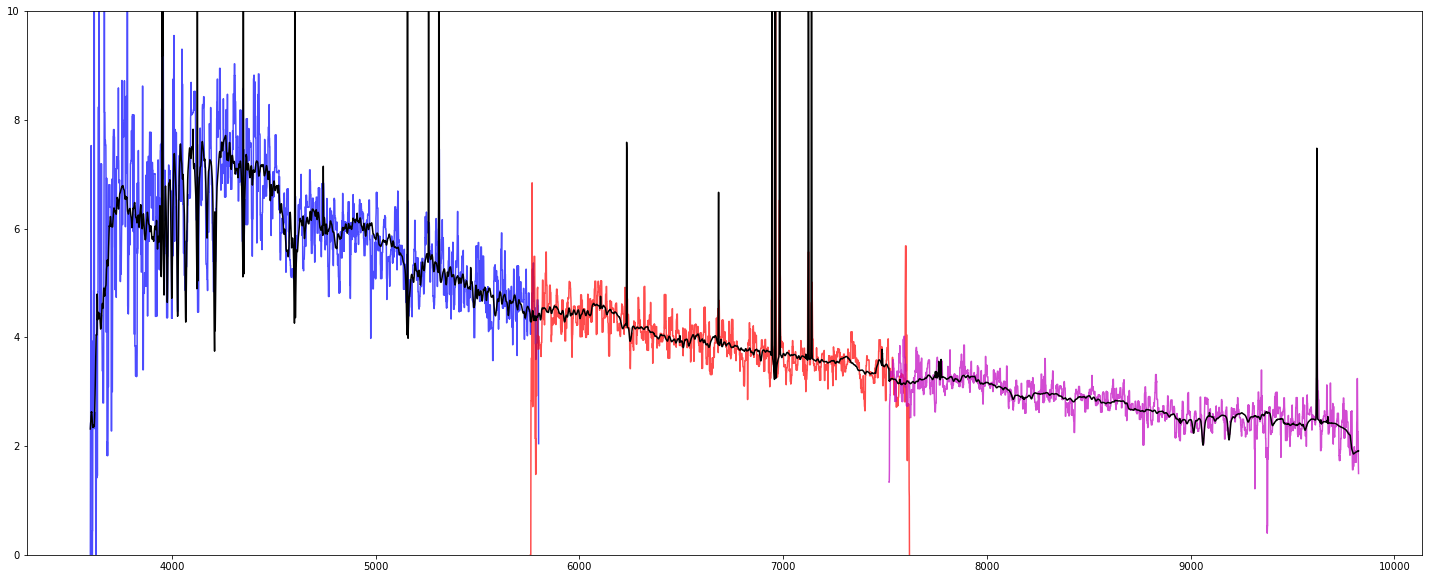

In [9]:
#plotting the spectra

wavelength = np.arange(3600, 9824+.8, .8) #DESI observed wavelength grid
fig, ax = plt.subplots()

camera_colors = ['b', 'r', 'm']
for i in range(len(cameras)):
    ax.plot(obs_wavelength[i], medfilt(obs_flux[i], kernel_size=11), color=camera_colors[i], alpha=.7)
    
ax.plot(wavelength, continuum+emission+smooth_continuum, color='k')

ax.set_ylim([0,10])